## Layout

A layout $L = (s_1, ..., s_k) : (d_1, ..., d_k)$ maps coordinates $\mathbf{c} = (c_1, \dots, c_k)$ to an index $p \in \mathbb{N}$:
$$
p = L(\mathbf{c}) = \sum_{i=1}^k c_i \cdot d_i = \sum_{i=1}^k L_i(c_i)
$$
where $k$ is called the *rank* of the layout, and the $i$ iterates through each dimension or *mode* of $L$.

The RHS defines a "sub-layout" at mode $i$ as $L_i = s_i:d_i$ where $s_i$ defines the domain and $d_i$ is a mapping stride.
A basic requirement for a layout is usually *non-overlapping*, meaning that if $R_i = \{ L_i(c_i) \}$ be the image of the $i$-th dimension, $\forall i \neq j$, we will have $R_i \cap R_j = \{0\}$ (i.e., *trivial Intersection*). 
This property is also named "disjoint", it implies
* Injective
* Reversibility of Addition (so that you can uncover $\mathbf{c}$ from $p$)

This notebook will use [./layout.py](layout.py) (a simplified implementation from reference [1, 2, 3, 4]) to illustrate certain basic layout algebra operations.

In these programs, we use `shape` and `stride` to name $s$ and $d$, besides, a layout’s shape and stride tuples must be *congruent*, that is, the two "tuples" need to have the same hierarchical structure.

domain and co-domain: 24 112


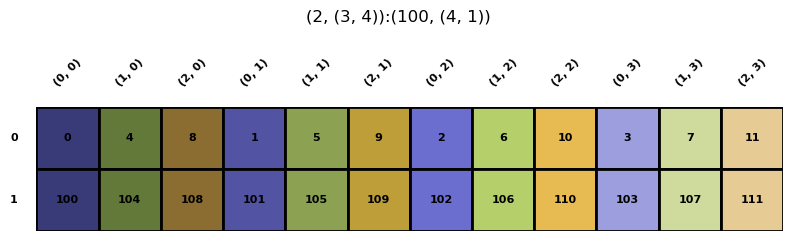

In [53]:
from layout import Layout
A = Layout(shape=(2, (3, 4)), stride=(100, (4, 1))).visualize()
print("domain and co-domain:", A.size(), A.cosize()) # these two are inequal because layout A is non-contiguous here.

A layout without specifying the strides is default to the *colexicographical order*, i.e., a generalized column-major order where the strides are the *prefix products* of its shapes:

((2, 2), (3, 4)):((1, 2), (4, 12))

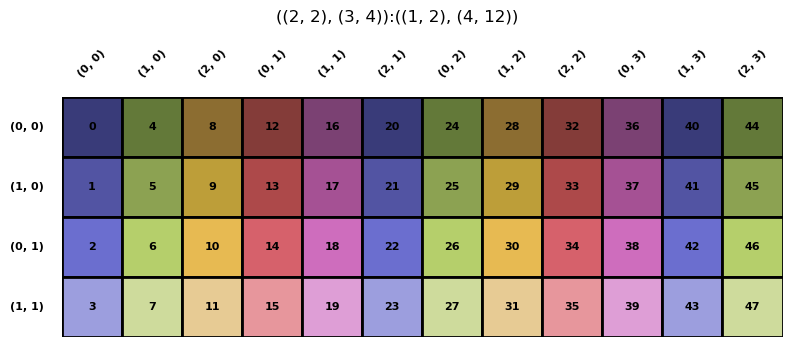

In [52]:
Layout(shape=((2, 2), (3, 4))).visualize()

## Coalesce
`coalesce` simplifies a layout. CuTe (Cutlass Tensor?) [1] defines that it targets and transform 3 cases:

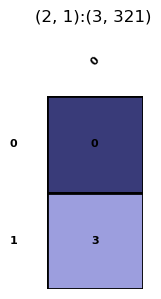

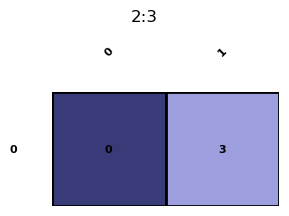

In [35]:
from layout import coalesce
# Case 1: s0:d0  ++  _1:d1  =>  s0:d0
A = Layout.from_string('(2,1):(3,321)').visualize()
B = coalesce(A).visualize()

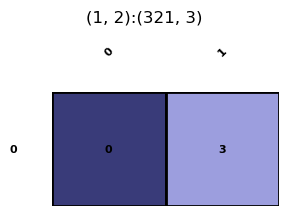

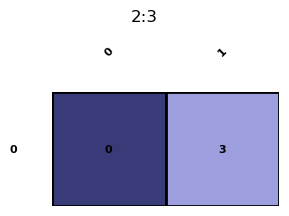

In [36]:
# Case 2: _1:d0  ++  s1:d1  =>  s1:d1
A = Layout.from_string('(1,2):(321, 3)').visualize()
B = coalesce(A).visualize()

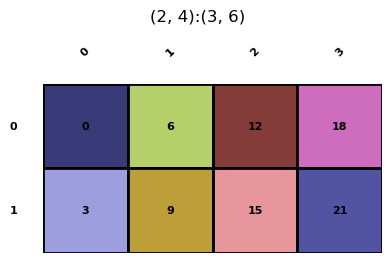

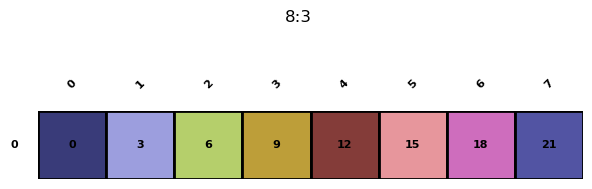

In [38]:
# Case 3: s0:d0  ++  s1:s0*d0  =>  s0*s1:d0
A = Layout.from_string('(2,4):(3,6)').visualize()
B = coalesce(A).visualize()

Note that it does not coalesce `(4, 2):(6, 3)` because CuTe coalesce from left-to-right. Vectorization of CuTe is usually done by `cute.max_common_layout` between source and destination layouts. It should be good for most of the common cases.

(4, 2):(6, 3)

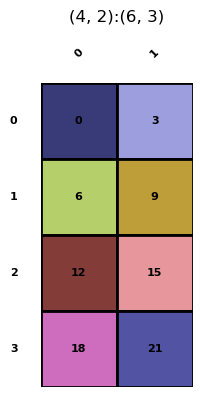

In [41]:
coalesce(Layout.from_string('(4,2):(6,3)')).visualize()

## Composition

As a result of the layout definition and requirement, we have a sum-distributive *composition*, namely,
$$
(A \circ B)(\mathbf{c}) = A \left( \sum_{i} B_i(c_i) \right) = \sum_{i} A(B_i(c_i)) = \sum_{i} (A \circ B_i)(c_i)
$$

Assume $A=A_s:A_d$ and $B_i(c_i) = c \cdot B_d$, then
$$
A(B_i(c_i)) = A(c_i \cdot B_d)
$$
which is essentially to determine a layout that produces every $B_d$-th element of $A$.

An example A / B_stride (so called "dividing out"):
* (3,6,2,8):(w,x,y,z) / 72
* = (ceil[3/72], ceil[6/24], ceil[2/4], ceil[8/2]):(72w, 24x, 4x, 2z)
* = (1, 1, 1, 4):(72w, 24x, 4x, 2z)

The shape of resulting layout should match $B$, hence composition also requires "modding out" shapes:
```python
remain_shape = other.shape
for each dimension:
    new_shape = min(new_shape, remain_shape)
    remain_shape = remain_shape // new_shape
```

In the following, we will show visualized examples (most are taken from CuTe docs [1]):

(3, 2):(10, 10)

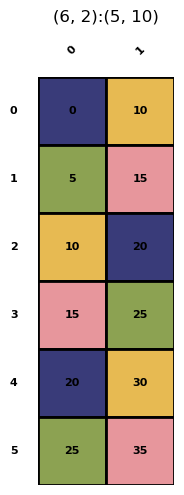

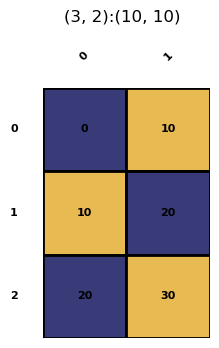

In [72]:
Layout.from_string('(6,2):(5,10)').visualize().composite(Layout.from_string('6:2')).visualize()

((2, 2), 3):((24, 2), 8)

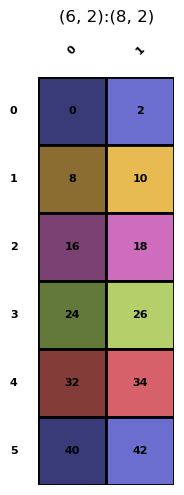

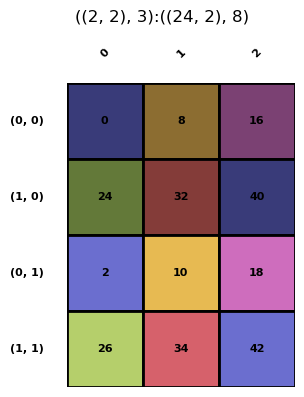

In [73]:
Layout.from_string('(6,2):(8,2)').visualize().composite(Layout.from_string('(4,3):(3,1)')).visualize()

(5, 4):(8, 2)

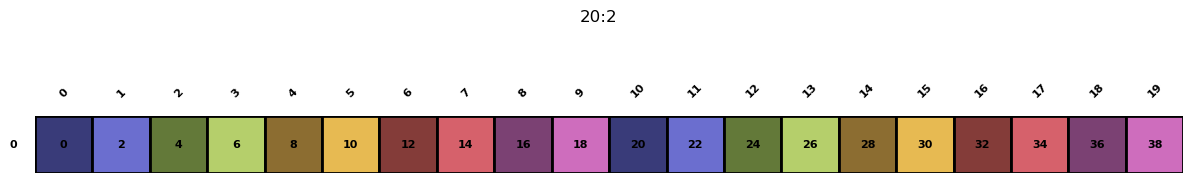

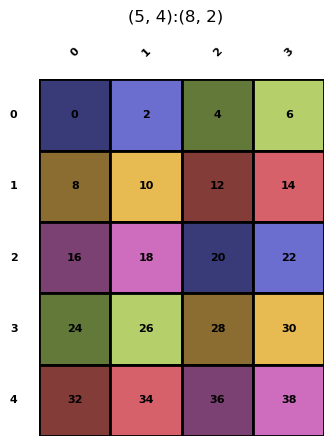

In [74]:
Layout.from_string('20:2').visualize().composite(Layout.from_string('(5,4):(4,1)')).visualize()

(5, (2, 2)):(16, (80, 4))

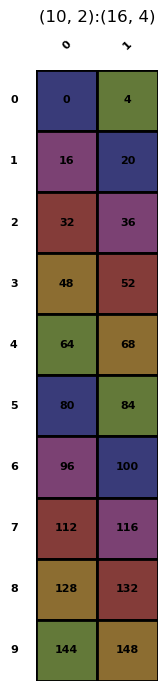

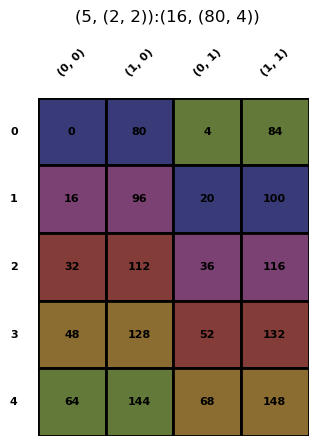

In [75]:
Layout.from_string('(10,2):(16,4)').visualize().composite(Layout.from_string('(5,4):(1,5)')).visualize()

## Reference
[1] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/media/docs/cpp/cute/02_layout_algebra.md

[2] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/python/pycute/layout.py

[3] https://docs.modular.com/mojo/kernels/layout/layout

[4] https://github.com/modular/modular/blob/61603e2f4990e65b6c962389a13a1c288d0fb47b/max/kernels/src/layout/layout.mojo

[5] https://docs.modular.com/mojo/manual/layout/layouts/